# TensorFlow Tutorial #17
# Estimator API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译[ZhouGeorge](https://github.com/ZhouGeorge)/[GitHub](https://github.com/ZhouGeorge/TensorFlow-Tutorials)

## Introduction介绍

在软件开发中高级API是相当重要的，因为它们可以为完成复杂的任务提供简单的描述。这样可以更简单地去完成和理解你的源码并且出错的风险很低。

在教程 #03中我们见过如何用不同的构筑API在Tensorflow中创建神经网络。然而，为了训练模型和在新的数据上使用它们需要添加很多的代码。 Estimator是另一个高级的API可以以完成其中的大部分工作，尽管它到底有多易用是有待讨论的。

使用 Estimator API 包括以下几个步骤：
1. 给 Estimator 定义输入数据的函数。
2. 或者使用一个已经存在的Estimator（例如 一个深度神经网络），它也可以称为预制（pre-made）或封装（Canned）的Estimator。或者创建一个你自己的Estimator，你需要定义优化器，评价指标，等等。
3. 利用步骤1.中定义的数据集训练Estimator。
4. 在步骤1.定义的测试机上评价Estimator的表现。
5. 用训练好的Estimator去预测其他的数据。

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/home/magnus/anaconda3/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


开发环境Python 3.6（Anaconda）和TensorFlow version：

译者注：Estimator需要1.3.0以上版本。

In [2]:
tf.__version__

'1.4.0'

## 加载数据

MNIST 数据集大学12MB，如果指定路径下不存在它会被自动下载。

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST数据集已经被加载了，它包含70000张图像和对应的标签（图像的分类）。数据集被划为3个子集。我们在这个教程中只需要用到训练集和测试集。

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


类别标签是独热编码，意味着每个标签是有10个元素的向量，除了一个元素外其余都是0，这个元素的索引就是对应图像的类数。我们也需要类别数的整数形式，所以我们就通过下面的计算。

In [5]:
data.train.cls = np.argmax(data.train.labels, axis=1)

In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

下面是独热编码的标签举例：

In [7]:
data.train.labels[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

下面是对应的类别数：

In [8]:
data.train.cls[0:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8])

## 数据的尺寸

数据的尺寸在下面多个地方被用到。它们被定义了一次，所以我们可以在下面的源代码中使用这些变量来代替数字。

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 画图的辅助函数

在3x3的网格中画9张图，包括在每张图下面显示正确的类别和预测的类别。

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 画一些图像检验数据是否正确

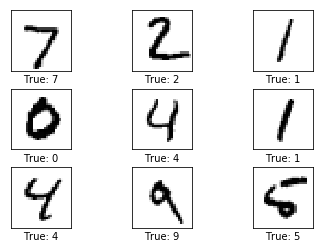

In [11]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Estimator 的输入函数

相较于直接给Estimator直接提供原始数据，我们必须提供一个函数来返回这些数据再输入。这允许在数据源上有更大的灵活性，例如可以对数据进行随机的清洗和迭代。

注意到我们将利用`DNNClassifier`来创建一个Estimator，它默认类别数为整形，所以我们要用`data.train.cls` 来代替`data.train.labels`（独热数组）。

这个函数为了能更好的控制数据的读取包含 `batch_size`, `queue_capacity` 和 `num_threads`参数。在这个例子中我们直接从内存中读取数据的numpy数组，所以在这里不需要这些。

In [12]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(data.train.images)},
    y=np.array(data.train.cls),
    num_epochs=None,
    shuffle=True)

这实际上返回一个函数：

In [13]:
train_input_fn

<function tensorflow.python.estimator.inputs.numpy_io.numpy_input_fn.<locals>.input_fn>

调用这个函数返回一个TensorFlow的返回输入和输出数据的操作的元组：

In [14]:
train_input_fn()

({'x': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(128, 784) dtype=float32>},
 <tf.Tensor 'random_shuffle_queue_DequeueMany:2' shape=(128,) dtype=int64>)

相同的，我们也需要需要创建一个用于读取测试集的函数。注意到我们只想要处理这些图像1次所以`num_epochs=1`并且我们不希望图像的顺序被打乱所以 `shuffle=False`。

In [15]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(data.test.images)},
    y=np.array(data.test.cls),
    num_epochs=1,
    shuffle=False)

还需要一个输入函数来预测新数据的类。作为一个例子我们只取了了测试集中的一部分图像。

In [16]:
some_images = data.test.images[0:9]

In [17]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": some_images},
    num_epochs=1,
    shuffle=False)

在这个输入函数中正确的类别数实际上没有被用到，因为在预测阶段这是不需要的。然而，正确的类别数在我们之后画图中需要用到。

In [18]:
some_images_cls = data.test.cls[0:9]

##  预制/封装 Estimator

当我们使用预制Estimator时，我们需要为数据指定输入特性。在这个例子中，我们希望从我们的data-set中输入图像，它们是给定形状的数字数组。

In [19]:
feature_x = tf.feature_column.numeric_column("x", shape=img_shape)

你可以有几个输入特性，然后将它们组合在一个列表中：

In [20]:
feature_columns = [feature_x]

在这个例子中我们想要用3个隐藏层的DNN，分别有512.256，128单元。

In [21]:
num_hidden_units = [512, 256, 128]

用`DNNClassifier`构筑我们的神经网络。我们也可以指定激活函数和其他不同的参数（见文档）。这里我们只指定分类的类别数量和checkpoints保存的地址。

In [22]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_tutorial17-1/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0028f03198>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### 训练

我们现在可以给定的迭代次数训练模型。这将自动加载并保存checkpoints，这样我们就可以在以后继续训练。

注意到`INFO:tensorflow:`在每一行都被打印，这有阻碍快速阅读进展。它应该被单独的打印一行。

In [23]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints_tutorial17-1/model.ckpt.
INFO:tensorflow:loss = 300.688, step = 1
INFO:tensorflow:global_step/sec: 370.039
INFO:tensorflow:loss = 26.462, step = 101 (0.271 sec)
INFO:tensorflow:global_step/sec: 521.366
INFO:tensorflow:loss = 22.0528, step = 201 (0.191 sec)
INFO:tensorflow:global_step/sec: 549.886
INFO:tensorflow:loss = 32.07, step = 301 (0.182 sec)
INFO:tensorflow:global_step/sec: 548.856
INFO:tensorflow:loss = 13.8037, step = 401 (0.182 sec)
INFO:tensorflow:global_step/sec: 516.064
INFO:tensorflow:loss = 23.2653, step = 501 (0.194 sec)
INFO:tensorflow:global_step/sec: 552.268
INFO:tensorflow:loss = 17.7141, step = 601 (0.180 sec)
INFO:tensorflow:global_step/sec: 529.426
INFO:tensorflow:loss = 25.7157, step = 701 (0.189 sec)
INFO:tensorflow:global_step/sec: 513.375
INFO:tensorflow:loss = 5.08285, step = 801 (0.195 sec)
INFO:tensorflow:global_step/sec: 536.319
INFO:tensorflow:loss = 1

### 评估

一旦训练好模型，我们可以在测试集上评估它的性能。

In [24]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-11-17-12:07:56
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-1/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-11-17-12:07:56
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9727, average_loss = 0.0934177, global_step = 2000, loss = 11.825


In [25]:
result

{'accuracy': 0.9727,
 'average_loss': 0.093417682,
 'global_step': 2000,
 'loss': 11.825023}

In [26]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 97.27%


### 预测

训练好的模型也可以拿来预测新的数据。

注意到在对新数据预测时，TensorFlow图被再次创建并且加载checkpoint一次。如果模型非常大，这开销会是非常大的。

不知道为什么Estimator被设计成这种方式，可能是为了总是能加载最近的一个Checkpoint，它也可以很容易地分布在多台计算机上。

In [27]:
predictions = model.predict(input_fn=predict_input_fn)

In [28]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-1/model.ckpt-2000


In [29]:
cls_pred = np.array(cls, dtype='int').squeeze()
cls_pred

array([7, 2, 1, 0, 4, 1, 4, 9, 5])

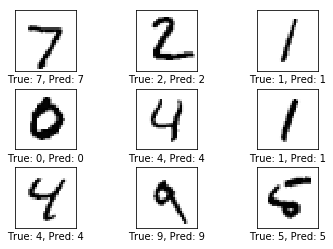

In [30]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

# 新的Estimator

如果你不使用内置的Estimator，那么你可以自己创建一个任意TensorFlow 模型。为了完成这个，你首先需要创建如下的几个函数：
1. TensorFlow 模型，例如一个卷积神经网络
2. 模型的输出。
3. 用于模型优化的损失函数。
4. 优化的方法。
5. 性能指标。

这个Estimator可以运行三种模式：训练，评估，或预测。这些代码大体相似，但是预测模式下我们不需要设置损失函数和优化器。

这是Estimator API的另一个方面，它被设计的糟糕，就像我们过去用结构体来做ANSI C编程一样。

In [31]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn,
    #           see e.g. train_input_fn for these two.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "x" in the input-function.
    x = features["x"]

    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])    

    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=16, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=36, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc2',
                          units=10)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode（如果是在预测模式下，预测的类别是神经网络的输出。优化等等是不需要的。
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function（注意损失函数在评估模式下也是需要的）
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first（定义用于优化的损失函数，首先计算网络输出和真实标签的交叉熵）
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.（封装成Estimator的规格）
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

### 创建Estimator的一个实例

我们可以指定超参数，例如优化器的学习率。

In [32]:
params = {"learning_rate": 1e-4}

我们可以创建这个新的Estimator的一个实例。

注意我们没有提供feature-columns，因为它会当`model_fn()`被调用时，从data-functions自动推断出来。

在TensorFlow文档中写的不清楚，为什么在上面使用`DNNClassifier`必须指定feature-columns，而这里不需要。 

In [33]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./checkpoints_tutorial17-2/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00290fac88>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### 训练

现在我们新的Estimator已经被创建，我们可以训练它。

In [34]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints_tutorial17-2/model.ckpt.
INFO:tensorflow:loss = 2.33444, step = 1
INFO:tensorflow:global_step/sec: 190.454
INFO:tensorflow:loss = 0.810317, step = 101 (0.527 sec)
INFO:tensorflow:global_step/sec: 198.129
INFO:tensorflow:loss = 0.349305, step = 201 (0.504 sec)
INFO:tensorflow:global_step/sec: 184.116
INFO:tensorflow:loss = 0.288062, step = 301 (0.543 sec)
INFO:tensorflow:global_step/sec: 195.138
INFO:tensorflow:loss = 0.0948148, step = 401 (0.512 sec)
INFO:tensorflow:global_step/sec: 199.116
INFO:tensorflow:loss = 0.203272, step = 501 (0.502 sec)
INFO:tensorflow:global_step/sec: 190.777
INFO:tensorflow:loss = 0.22347, step = 601 (0.524 sec)
INFO:tensorflow:global_step/sec: 198.669
INFO:tensorflow:loss = 0.161297, step = 701 (0.505 sec)
INFO:tensorflow:global_step/sec: 192.277
INFO:tensorflow:loss = 0.154663, step = 801 (0.518 sec)
INFO:tensorflow:global_step/sec: 158.865
INFO:tensorfl

### 评估

模型一旦被训练好，我们可以在测试集上去评估它的性能。

In [35]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-11-17-12:08:18
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-2/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-11-17-12:08:18
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9761, global_step = 2000, loss = 0.0760049


In [36]:
result

{'accuracy': 0.97610003, 'global_step': 2000, 'loss': 0.076004863}

In [37]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 97.61%


### 预测

模型也可以用来在新的数据上进行预测

In [38]:
predictions = model.predict(input_fn=predict_input_fn)

In [39]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-2/model.ckpt-2000


array([7, 2, 1, 0, 4, 1, 4, 9, 5])

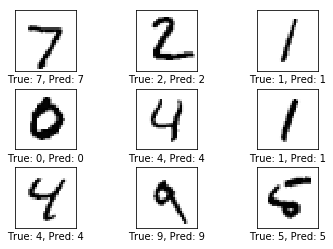

In [40]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

## 总结

这个教程展示给我们如何在TensorFlow中去使用Estimator API。它被认为可以使训练和使用模型变得更容易，但它似乎有几个设计问题：

* Estimator API是复杂的，不一致的并且有些让人困惑。
* 错误报告相当长并且经常难以理解。
* 当你想用一个训练好的模型去预测新的数据，每一次 TensorFlow的图都会被再次创建并且加载checkpoint一次。有一些模型非常大所以这可能会会是一个很大的开销。一个更好的方法是，如果检查点在磁盘上发生了变化，则只重新载入模型。
* 目前还不清楚如何获得训练好的模型，例如画出神经网络的权重。

似乎Estimator API可以更简单，更容易使用。对于小的项目你可能发现它太复杂了并且困惑付出的努力是否值得，但。如果你有一个非常大的数据集，并且如果你在许多机器上进行训练，那么Estiator API是有用的。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 对每个模型运行另10000训练的迭代。
* 在优化之前和经过1000，2000，10000次迭代后，打印测试集上印分类的准确率。
* 在Estimator里改变神经网络的结构。你需要删除checkpoint文件吗？为什么？
* 改变input-functions的batch-size。
* 在之前的教程中我们画出被错误分类的图像。请在这也完成。
* 改变Estimator，用独热编码标签代替整数类别。
* 改变input-functions去加载图像文件来代替numpy数组。
* 你能找到一个方法来画出神经网络每一层的权重和输出吗？
* 列出5个你喜欢和不喜欢Estimator API的点。你有什么改进的建议？也与你应该给开发者一些建议？
* 向朋友解释程序是如何工作的。

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.